# The relationship between US interest rates and public debt in developing countries

# Table of Contents
1. [Introduction](#introduction)
2. [Set up of the Workspace](#setup-of-the-workspace)
   1. [Packages](#packages)
   2. [Data](#data)
3. [Data](#data)
   1. [FRED](#fred)
   2. [World Bank](#world-bank)
   3. [Append FRED and World Bank](#append-fred-and-world-bank)
   4. [Classification of countries by income group](#classification-of-countries-by-income-group)
   5. [Aggregated data](#aggregated-data)
4. [Analysis](#analysis)
   1. [Descriptive graphs](#descriptive-graphs)
   2. [Models](#models)
5. [Conclusion](#conclusion)

## Introduction

In February 2022, the world was impacted by the Russo-Ukrainian war, heightening global risks and uncertainty. Economies slowed down, and their outlooks became increasingly fragile and imbalanced. This war also intensified inflationary pressures. As a result, most advanced economies, including the United States, tightened their monetary policies. The rise in U.S. interest rates increased the public debt of developing countries denominated in dollars, raising their risk of default and increasing the likelihood of economic crises.

Higher U.S. interest rates boost foreign demand for U.S. investments and U.S. dollars, leading to an appreciation of the dollar relative to other currencies. This rise in U.S. interest rates results in higher interest repayments on external debt for developing countries. Furthermore, the depreciation of local currencies against the dollar increases the value of their debt in local currency terms.

In this project, I aim to investigate the relationship between U.S. interest rates and public debt in developing countries. Specifically, I will examine whether the aforementioned mechanism holds in practice using data. I use data from 1960 to 2023 from FRED and the World Bank, including interest rates, external debt, exchange rates, GNI, population, economic development, and region. I implement two types of models: 1) OLS and 2) ARMAX. Ultimately, in the most appropriate OLS and ARMAX models, I find that a one-percentage-point increase in U.S. interest rates is associated with an 8-10 percentage point rise in external debt (as a percentage of GNI).



## Setup of the Workspace

### Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import os 
import patsy
import itertools

from statsmodels.iolib.summary2 import summary_col

### Paths

In [2]:
ROOT = os.path.dirname(os.getcwd())

PATH_DATA = os.path.join(ROOT, 'data')


## Data

### FRED
contains data on US interest rates

In [3]:
# Download and read the CSV directly into a DataFrame
#df_fred = pd.read_csv("C:/Users/Maude/OneDrive/Documents/etudes/UZH/PhD/2nd year/first semester/programming/project/data/FEDFUNDS.csv")

df_fred_raw = pd.read_csv(os.path.join(PATH_DATA, 'FEDFUNDS.csv')) #.replace('\\', '/'))

#convert monthly data to yearly data

## Convert the date column to datetime format
df_fred_raw['DATE'] = pd.to_datetime(df_fred_raw['DATE'])

## Filter the DataFrame to include only rows where the month is January
df_fred_raw_year = df_fred_raw[df_fred_raw['DATE'].dt.month == 1]

## Extract and keep only the year
df_fred_raw_year['DATE'] = df_fred_raw_year['DATE'].dt.year



#convert data to same format as WB to append

## Add columns for 'Country Name' and 'Country Code'
df_fred_raw_year['Country Name'] = 'United States'

df_fred_raw_year['Country Code'] = 'USA'

## Rename the columns
df_fred_raw_year.rename(columns={'DATE': 'YEAR', 'FEDFUNDS': 'Series Name'}, inplace=True)

df_fred_raw_year.head(10)

## Convert the DataFrame from long format to wide format
df_fred_raw_wide = df_fred_raw_year.pivot(index=['Country Name', 'Country Code'], columns='YEAR', values='Series Name')

## Add a new column 'Series name' with the value 'Interest rate'
df_fred_raw_wide['Series Name'] = 'Interest rate'
df_fred_raw_wide['Country Name'] = 'United States'
df_fred_raw_wide['Country Code'] = 'USA'

## Drop the columns 1955, 1956, 1957, 1958, 1959, 2024
df_fred_raw_wide.drop(columns=[1955, 1956, 1957, 1958, 1959, 2024], inplace=True)

df_fred_raw_wide.head(10)




C:\Users\Maude\AppData\Local\Temp\ipykernel_27268\3333035533.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fred_raw_year['DATE'] = df_fred_raw_year['DATE'].dt.year
C:\Users\Maude\AppData\Local\Temp\ipykernel_27268\3333035533.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fred_raw_year['Country Name'] = 'United States'
C:\Users\Maude\AppData\Local\Temp\ipykernel_27268\3333035533.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

,YEAR,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2017,2018,2019,2020,2021,2022,2023,Series Name,Country Name,Country Code
Country Name,Country Code,,,,,,,,,,,,,,,,,,,,,
United States,USA,3.99,1.45,2.15,2.92,3.48,3.9,4.42,4.94,4.61,6.3,...,0.65,1.41,2.4,1.55,0.09,0.08,4.33,Interest rate,United States,USA


### World Bank


contains data on GNI, GNI per capita, population, external debt stock (% of GNI), external debt stock, official exchange rate, currency composition of PPG

In [4]:
#Load World Bank dataset containing most of the variables

df_WB_raw = pd.read_csv(os.path.join(PATH_DATA, 'World_Bank_data.csv')) #.replace('\\', '/'))
#df_WB_raw.head()
#df_WB_raw.shape


In [5]:
#Load World Bank dataset containing currency composition of debt

df_WB_comp_raw = pd.read_csv(os.path.join(PATH_DATA, 'World_Bank_composition.csv')) #.replace('\\', '/'))
#df_WB_comp_raw.shape
#df_WB_comp_raw.head()

In [6]:
### Appended dataframes

# Append WB dataframes
WB_df_raw = pd.concat([df_WB_raw, df_WB_comp_raw], ignore_index=True)

# Delete columns Counterpart-Area Code and Counterpart-Area Name

WB_df_raw_del = WB_df_raw.drop(columns=['Counterpart-Area Code', 'Counterpart-Area Name'])

# Rename years columns

## Create a dictionary to map old column names to new column names
rename_dict = {col: col.split('[')[0] for col in WB_df_raw_del.columns if '[' in col}

## Rename the columns
WB_df_raw_del.rename(columns=rename_dict, inplace=True)

# Create a dictionary to map old column names to new column names
rename_dict = {f'{year} ': year for year in range(1960, 2024)}

# Rename the columns
WB_df_raw_del.rename(columns=rename_dict, inplace=True)

WB_df_raw_del.head()


,Country Name,Country Code,Series Name,Series Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,External debt stocks (% of GNI),DT.DOD.DECT.GN.ZS,..,..,..,..,..,..,...,12.3049882430693,13.4908300391384,14.1470450328557,14.5133427332625,14.6424246274665,13.9496520911751,15.1208585234171,24.7744403222298,..,..
1,Afghanistan,AFG,"External debt stocks, total (DOD, current US$)",DT.DOD.DECT.CD,..,..,..,..,..,..,...,2529865267.8,2596917266.2,2596050086.4,2751986638.9,2678760424.2,2661685956.5,3040072312.4,3555784339.6,3393247241.7,..
2,Afghanistan,AFG,"Official exchange rate (LCU per US$, period av...",PA.NUS.FCRF,17.1965606878624,17.1965606878624,17.1965606878624,35.1096447377192,38.6922615476905,38.6922615476905,...,57.2475,61.1434615416667,67.8660857692308,68.0269040822312,72.083247177304,77.7379491783367,76.8135364354897,..,..,..
3,Afghanistan,AFG,GNI (current US$),NY.GNP.MKTP.CD,548888848.888889,560000022.222222,557777806.666667,766666706.666667,815555562.222222,1026666677.77778,...,20559672324.9094,19249499438.7455,18350475875.2999,18961769787.4548,18294513957.5523,19080662010.7479,20105156769.1907,14352632363.74,14545219074.5763,..
4,Afghanistan,AFG,"GNI per capita, PPP (current international $)",NY.GNP.PCAP.PP.CD,..,..,..,..,..,..,...,2240,2300,2250,2360,2470,2630,2590,2150,2100,..


### Append FRED and World Bank

In [7]:
data_FRED_WB_wide = pd.concat([WB_df_raw_del, df_fred_raw_wide], ignore_index=True)

# Replace values equal to '..' with NaN
data_FRED_WB_wide.replace('..', np.nan, inplace=True)

# Drop rows where the "Country Code" column contains NaN
data_FRED_WB_wide.dropna(subset=['Country Code'], inplace=True)

# Drop column Series Code
data_FRED_WB_wide.drop(columns='Series Code', inplace=True)

# Convert the DataFrame from wide format to long format
data_FRED_WB_long = pd.melt(data_FRED_WB_wide, id_vars=['Country Name', 'Country Code', 'Series Name'], var_name='Year', value_name='Value')

#data_FRED_WB_long.head(10)


### Classification of countries by income group

The data provided by the World Bank contains information on the geography and economic development of countries. This data will be merged to the datasets `data_FRED_WB_wide` and `data_FRED_WB_long`.

In [8]:
# Open the World Bank classification file
WB_class_raw = pd.read_excel(os.path.join(PATH_DATA, 'World_Bank_classification.xlsx'))

# Drop the column "Lending category"

WB_class_raw.drop(columns='Lending category', inplace=True)

# Rename the columns "Economy" and "Code"

WB_class_raw.rename(columns={'Economy': 'Country Name', 'Code': 'Country Code'}, inplace=True)

# Merge the data_FRED_WB_wide DataFrame with the WB_class_raw DataFrame

data_FRED_WB_wide = pd.merge(data_FRED_WB_wide, WB_class_raw, on=['Country Name', 'Country Code'], how='left')

# Merge the data_FRED_WB_long DataFrame with the WB_class_raw DataFrame

data_FRED_WB_long = pd.merge(data_FRED_WB_long, WB_class_raw, on=['Country Name', 'Country Code'], how='left')

data_FRED_WB_long.head(10)
#os.path.join(PATH_DATA, 'World_Bank_classification.xlsx')

,Country Name,Country Code,Series Name,Year,Value,Region,Income group
0,Afghanistan,AFG,External debt stocks (% of GNI),1960,NaN,South Asia,Low income
1,Afghanistan,AFG,"External debt stocks, total (DOD, current US$)",1960,NaN,South Asia,Low income
2,Afghanistan,AFG,"Official exchange rate (LCU per US$, period av...",1960,17.1965606878624,South Asia,Low income
3,Afghanistan,AFG,GNI (current US$),1960,548888848.888889,South Asia,Low income
4,Afghanistan,AFG,"GNI per capita, PPP (current international $)",1960,NaN,South Asia,Low income
5,Afghanistan,AFG,"Population, total",1960,8622466,South Asia,Low income
6,Albania,ALB,External debt stocks (% of GNI),1960,NaN,Europe & Central Asia,Upper middle income
7,Albania,ALB,"External debt stocks, total (DOD, current US$)",1960,NaN,Europe & Central Asia,Upper middle income
8,Albania,ALB,"Official exchange rate (LCU per US$, period av...",1960,NaN,Europe & Central Asia,Upper middle income
9,Albania,ALB,GNI (current US$),1960,NaN,Europe & Central Asia,Upper middle income


In [9]:
# create an additional wide format dataframe

## Convert 'Value' and 'Year' column to numeric, coercing errors to NaN

data_FRED_WB_long['Year'] = pd.to_numeric(data_FRED_WB_long['Year'], errors='coerce')
data_FRED_WB_long['Value'] = pd.to_numeric(data_FRED_WB_long['Value'], errors='coerce')

## Create a pivot table to transform the data from long format to wide format

df_FRED_WB_wide2 = data_FRED_WB_long.pivot_table(index=['Country Name', 'Country Code', 'Year', 'Region', 'Income group'], columns='Series Name', values='Value').reset_index()
df_FRED_WB_wide2.head(10)


Series Name,Country Name,Country Code,Year,Region,Income group,"Currency composition of PPG debt, U.S. dollars (%)",External debt stocks (% of GNI),"External debt stocks, total (DOD, current US$)",GNI (current US$),"GNI per capita, PPP (current international $)",Interest rate,"Official exchange rate (LCU per US$, period average)","Population, total"
0,Afghanistan,AFG,1960,South Asia,Low income,NaN,NaN,NaN,5.488888e+08,NaN,NaN,17.196561,8622466.0
1,Afghanistan,AFG,1961,South Asia,Low income,NaN,NaN,NaN,5.600000e+08,NaN,NaN,17.196561,8790140.0
2,Afghanistan,AFG,1962,South Asia,Low income,NaN,NaN,NaN,5.577778e+08,NaN,NaN,17.196561,8969047.0
3,Afghanistan,AFG,1963,South Asia,Low income,NaN,NaN,NaN,7.666667e+08,NaN,NaN,35.109645,9157465.0
4,Afghanistan,AFG,1964,South Asia,Low income,NaN,NaN,NaN,8.155556e+08,NaN,NaN,38.692262,9355514.0
5,Afghanistan,AFG,1965,South Asia,Low income,NaN,NaN,NaN,1.026667e+09,NaN,NaN,38.692262,9565147.0
6,Afghanistan,AFG,1966,South Asia,Low income,NaN,NaN,NaN,1.428889e+09,NaN,NaN,38.692262,9783147.0
7,Afghanistan,AFG,1967,South Asia,Low income,NaN,NaN,NaN,1.708889e+09,NaN,NaN,38.692262,10010030.0
8,Afghanistan,AFG,1968,South Asia,Low income,NaN,NaN,NaN,1.402222e+09,NaN,NaN,38.692262,10247780.0
9,Afghanistan,AFG,1969,South Asia,Low income,NaN,NaN,NaN,1.437778e+09,NaN,NaN,38.692262,10494489.0


### Aggregated data

A database aggregated by `income group` and `Year` and weighted by `Population` will be created

In [10]:
# Define a function to compute the weighted mean
def weighted_mean(df, value_col, weight_col):
    return (df[value_col] * df[weight_col]).sum() / df[weight_col].sum()

# List of columns to compute the weighted mean for, excluding non-numeric columns

value_columns = df_FRED_WB_wide2.columns.difference(['Country Name', 'Country Code', 'Year', 'Region', 'Income group', 'Series Name'])

# Group by 'Income group' and 'Year' and compute the weighted mean for each column
data_FRED_WB_agg = df_FRED_WB_wide2.groupby(['Income group','Year']).apply(
    lambda x: pd.Series({col: weighted_mean(x, col, 'Population, total') for col in value_columns})
).reset_index()

# Display the aggregated DataFrame

data_FRED_WB_agg.head(10)

C:\Users\Maude\AppData\Local\Temp\ipykernel_27268\3154652203.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_FRED_WB_agg = df_FRED_WB_wide2.groupby(['Income group','Year']).apply(


,Income group,Year,"Currency composition of PPG debt, U.S. dollars (%)",External debt stocks (% of GNI),"External debt stocks, total (DOD, current US$)",GNI (current US$),"GNI per capita, PPP (current international $)",Interest rate,"Official exchange rate (LCU per US$, period average)","Population, total"
0,High income,1960,0.0,0.0,0.0,1.328527e+11,0.0,0.803577,78.535650,8.096386e+07
1,High income,1961,0.0,0.0,0.0,1.401260e+11,0.0,0.293369,80.047231,8.209489e+07
2,High income,1962,0.0,0.0,0.0,1.516711e+11,0.0,0.436427,79.951884,8.317353e+07
3,High income,1963,0.0,0.0,0.0,1.618765e+11,0.0,0.594239,79.778616,8.423124e+07
4,High income,1964,0.0,0.0,0.0,1.755269e+11,0.0,0.709763,82.150669,8.527349e+07
5,High income,1965,0.0,0.0,0.0,1.909274e+11,0.0,0.796427,83.700741,8.626315e+07
6,High income,1966,0.0,0.0,0.0,2.095886e+11,0.0,0.904097,83.867247,8.707022e+07
7,High income,1967,0.0,0.0,0.0,2.231426e+11,0.0,1.011640,83.958111,8.783099e+07
8,High income,1968,0.0,0.0,0.0,2.434927e+11,0.0,0.944672,85.159531,8.856356e+07
9,High income,1969,0.0,0.0,0.0,2.659502e+11,0.0,1.291727,85.627000,8.932723e+07


A database aggregated by `income group` and weighted by `Population` will be created

In [11]:
# Group by 'Income group' and compute the weighted mean for each column
data_FRED_WB_agg2 = df_FRED_WB_wide2.groupby(['Income group']).apply(
    lambda x: pd.Series({col: weighted_mean(x, col, 'Population, total') for col in value_columns})
).reset_index()

# Drop the interest rate column
data_FRED_WB_agg2 = data_FRED_WB_agg2.drop(columns=['Interest rate'])

# Custom order of rown
custom_order = [1,2,3,0] 
data_FRED_WB_agg2 = data_FRED_WB_agg2.reindex(custom_order)

C:\Users\Maude\AppData\Local\Temp\ipykernel_27268\1898106049.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_FRED_WB_agg2 = df_FRED_WB_wide2.groupby(['Income group']).apply(


## Analysis

In this analysis, I explore whether the US interest rate is associated with the external public debt of developing countries. The idea would be that an increase in the US interest rates attracts foreign investment in the US, which appreciates the dollar relative to other currencies. As a consequence, countries whose debt is largely denominated in US dollar and whose local currency depreciated relative to the US dollar should observe an increase in the real value of their public debt. Indeed, the repayment of the public debt in their local currency has increased as the local currency depreciated.

I focus on low income and lower middle income countries because they are the most at risk to be distressed and to run into a debt crisis due to low fiscal capacity.

### Descriptive graphs

#### Descriptive statistics on variables by income group

In [12]:
data_FRED_WB_agg2

,Income group,"Currency composition of PPG debt, U.S. dollars (%)",External debt stocks (% of GNI),"External debt stocks, total (DOD, current US$)",GNI (current US$),"GNI per capita, PPP (current international $)","Official exchange rate (LCU per US$, period average)","Population, total"
1,Low income,42.319812,42.712786,5.994686e+09,1.616224e+10,950.803606,509.588015,3.278125e+07
2,Lower middle income,51.238943,26.898451,1.144295e+11,6.001692e+11,2949.944033,754096.570089,5.723966e+08
3,Upper middle income,48.446403,17.757349,3.283322e+11,2.388441e+12,6314.584336,990.451445,6.826587e+08
0,High income,5.098983,3.136703,2.059817e+10,3.042900e+12,20338.376482,92.210275,1.097915e+08


Let's start by looking at the variables by the income group to understand better the characteristics of the different income groups. I aggregate the variables by income group weighting by the population of each country. In other words, my aggregation gives more weight to countries with large population size.

In the table, the `GNI per capita, PPP (current international $)` in low income countries is on average 951$, 2950$ in lower middle income countries, and 20338 in high income countries. These differences are very large. It might be surprising that the GNI per capita in lower middle income countries is three times larger than in low income countries. This means that these two groups of countries have significantly different income levels and are at distinct stages in their economic development. 

The `official exchange rate (LCU per US$, period average)` of low income countries is the second lowest; at first glance, this might seem surprising, but one has to keep in mind that several of these countries have had their exchange rate pegged for a long time ([Caramazza(1998)](https://www.imf.org/external/pubs/ft/issues13/)). The exchange rate of lower middle income is tremendously high in comparison to other income categories. However, this is driven by the extreme currency loss that occured in Zimbabwe in 2008.

The `external debt stocks (% of GNI)` seems negatively correlated with countries' level of development. Thus, low income countries have an external debt of 43% and are particularly vulnerable to a debt crisis. The external debt of lower middle income countries is about 27%. The `currency composition of PPG debt, U.S. dollars (%)` is at similar levels around 40-50% for low income, lower middle income and upper middle income countries.

#### The geography of low income and lower middle income countries

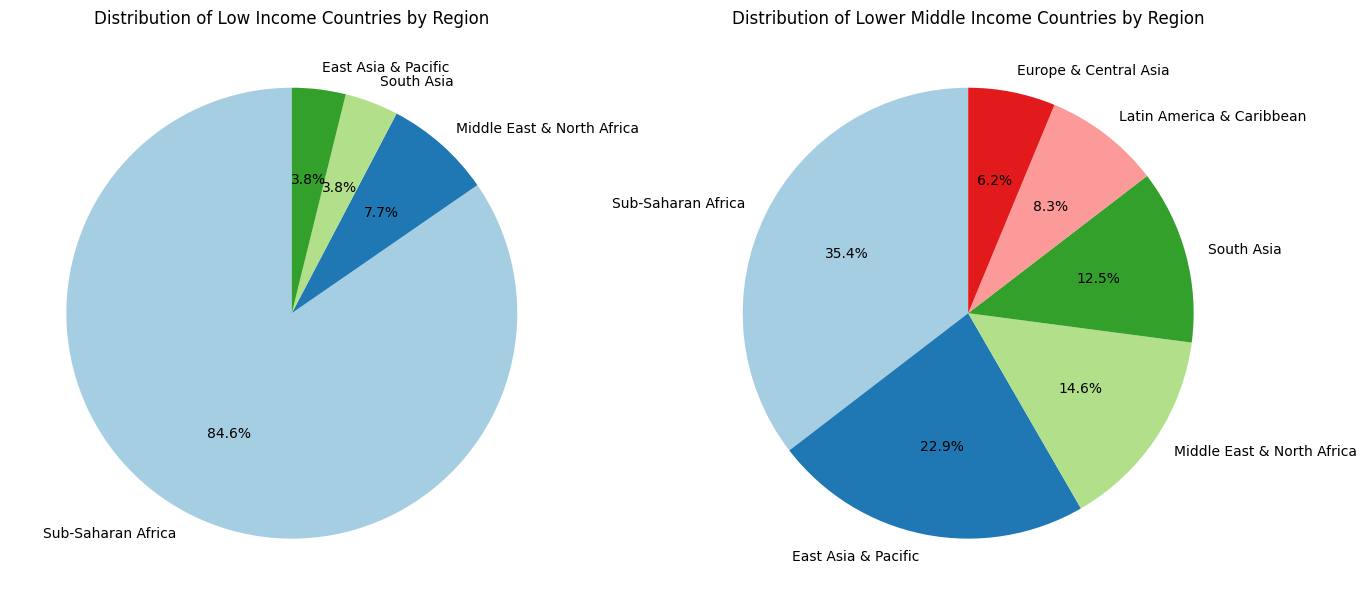

In [13]:
# Filter the DataFrame to include only low-income countries and lowe-middle-income countries
df_low_income = df_FRED_WB_wide2[(df_FRED_WB_wide2['Income group'] == 'Low income') & (df_FRED_WB_wide2['Year'] == 2022)]
df_low_middle_income = df_FRED_WB_wide2[(df_FRED_WB_wide2['Income group'] == 'Lower middle income') & (df_FRED_WB_wide2['Year'] == 2022)]

# Group by 'Region' and count the number of occurrences for each region
region_counts_low = df_low_income['Region'].value_counts()
region_counts_low_middle = df_low_middle_income['Region'].value_counts()

# Create the pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart for low income countries
ax1.pie(region_counts_low, labels=region_counts_low.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
ax1.set_title('Distribution of Low Income Countries by Region')

# Pie chart for lower middle income countries
ax2.pie(region_counts_low_middle, labels=region_counts_low_middle.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
ax2.set_title('Distribution of Lower Middle Income Countries by Region')

plt.show()


I display the regions of low income and lower middle income countries, which will be the focus in this analysis, to improve our understanding of these countries. Low income and lower middle income countries diverge also in their geography. While low income countries are mainly located in Sub-Saharan Africa (85%), lower middle income countries are in several regions such as Sub-Saharan Africa (35%), East Asia & Pacific (23%) and Middle East & North Africa (15%).

#### The relationship between US interest rates and exchange rates in developing countries

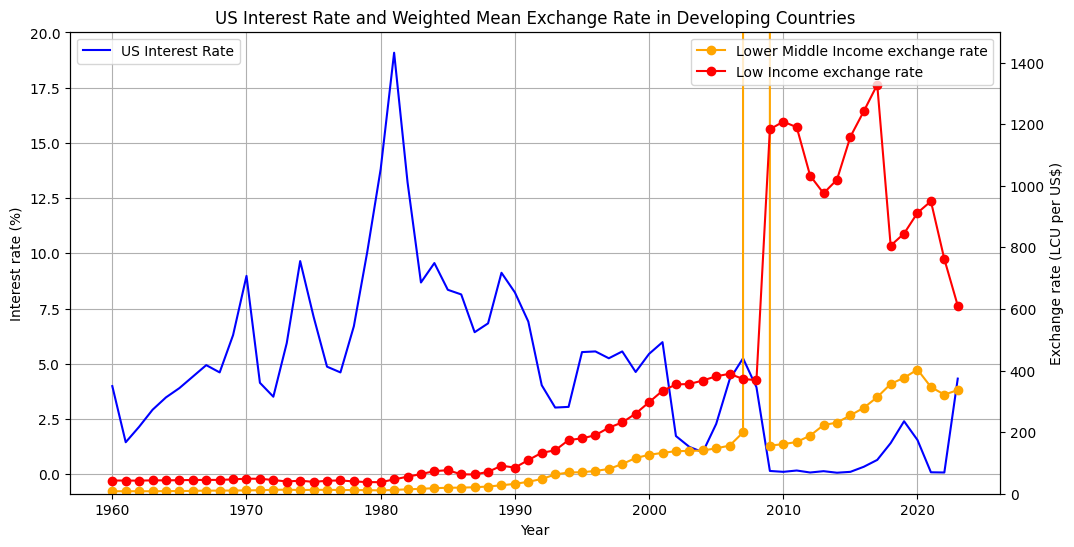

In [14]:
# plot the US interest rate over time and the currencies of low income countries as well as of lower middle income countries

## Filter the data_FRED_WB_wide2 DataFrame to include only rows where the "Country Name" column is equal to "United States" and keep only the columns Country name, Country code, Year and interest rate

df_USA_interest_rate = df_FRED_WB_wide2[(df_FRED_WB_wide2['Country Name'] == 'United States') & (df_FRED_WB_wide2['Interest rate'].notnull())]


## Filter the data_FRED_WB_agg to include only rows where the "Income group" column is equal to "Low income" and "Lower middle income"

df_low_income_agg = data_FRED_WB_agg[data_FRED_WB_agg['Income group'] == 'Low income']

df_lower_middle_income_agg = data_FRED_WB_agg[data_FRED_WB_agg['Income group'] == 'Lower middle income']

## Plot

# Plot the US interest rate and weighted mean exchange rate over time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the US interest rate on the first y-axis
ax1.plot(df_USA_interest_rate['Year'], df_USA_interest_rate['Interest rate'], color='blue', label='US Interest Rate')
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest rate (%)')
ax1.set_title('US Interest Rate and Weighted Mean Exchange Rate in Developing Countries')
ax1.grid()
ax1.legend(loc='upper left')

# Create a second y-axis for the exchange rates
ax2 = ax1.twinx()
ax2.plot(df_lower_middle_income_agg['Year'], df_lower_middle_income_agg['Official exchange rate (LCU per US$, period average)'], marker='o', color='orange', label='Lower Middle Income exchange rate')
ax2.plot(df_low_income_agg['Year'], df_low_income_agg['Official exchange rate (LCU per US$, period average)'], marker='o', color='red', label='Low Income exchange rate')
ax2.set_ylabel('Exchange rate (LCU per US$)')
ax2.set_ylim(0, 1500)  # 2008 is an outlier for lower middle income countries because of Zimbabwe
ax2.legend(loc='upper right')

plt.show()

#df_USA_interest_rate.head(10)


First, I investigate the relationship between the US interest rates and the exchange rates in developing countries. In theory, if exchange rates are floating, the US interest rates and the exchange rates should be positively correlated: A rise in the US interest rates would increase foreign demand for investment in the US, and therefore, increase the demand for US dollar relative to other currencies. The dollar would appreciate and other currencies would depreciate relative to the dollar, which translates into an increase in the `exchange rate (LCU per US$)`.

The correlation between US interest rate and exchange rates in developing countries is not clear.

Between 1960 and 1990, the US interest rates are at high levels and pretty volatile. By contrast, exchange rates in low income countres and lower middle income countries are at low levels in historic perspective and not volatile. The stability might result from fixed exchange rate regimes. It is important to note that during this period, exchange rates have an increasing trend, but the scale of the graph does not show this upward trend clearly.

After 1990, the US interest rates is at lower levels and less volatile. From 2009, it has even reached the zero lower bound for many periods. Exchange rates are on a clear increasing trend. The exchange rates in lower middle income countries have a clear and steady increasing trend. With the exception of 2008, where it explodes, but this is driven by Zimbabwe and the huge loss of value of its currency. The exchange rates of low income countries also have this steady increasing trend until 2008. After the Great Financial Crisis, they reach very high levels and are volatile. 

#### The role of external debt composition

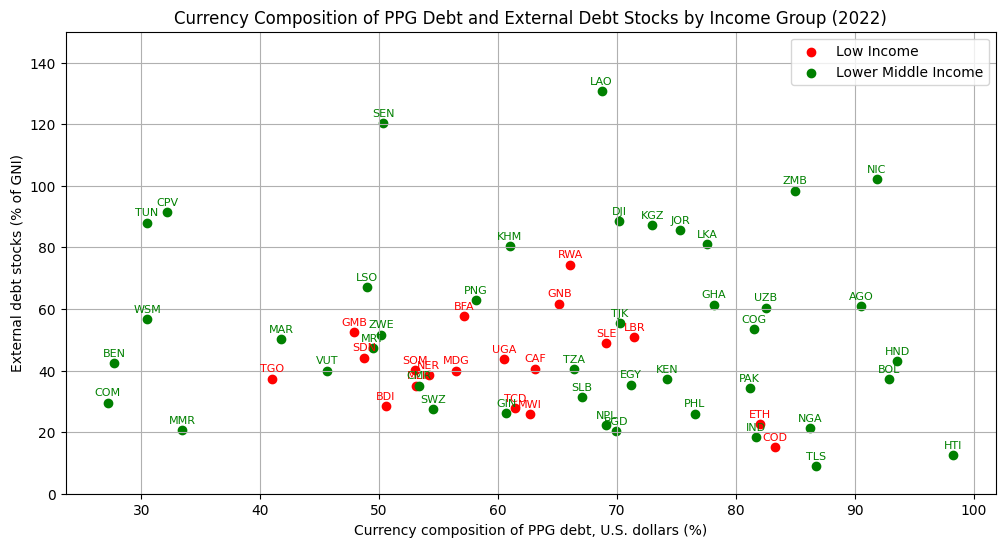

In [15]:
# Plot Currency composition of PPG debt, U.S. dollars (%) and external debt stocks (% of GNI) by income group

## Filter the data_FRED_WB_wide2 Dataframe to include only the year 2022

df_wide_2022 = df_FRED_WB_wide2[df_FRED_WB_wide2['Year'] == 2022]

## Filter the df_wide_2022 DataFrame to include only the income group 'low income' and 'lower middle income'
df_low_income_2022 = df_wide_2022[df_wide_2022['Income group'] == 'Low income']
df_lower_middle_income_2022 = df_wide_2022[df_wide_2022['Income group'] == 'Lower middle income']

df_lower_middle_income_2022.head(10)

## Plot
fig, ax = plt.subplots(figsize=(12, 6))

## Scatter plot for low income group
scatter_low_income = ax.scatter(df_low_income_2022['Currency composition of PPG debt, U.S. dollars (%)'], 
                                df_low_income_2022['External debt stocks (% of GNI)'], 
                                color='red', label='Low Income')

## Scatter plot for lower middle income group
scatter_lower_middle_income = ax.scatter(df_lower_middle_income_2022['Currency composition of PPG debt, U.S. dollars (%)'], 
                                         df_lower_middle_income_2022['External debt stocks (% of GNI)'], 
                                         color='green', label='Lower Middle Income')

## Annotate each point with the country code for low income group
for i, row in df_low_income_2022.iterrows():
    ax.annotate(row['Country Code'], 
                (row['Currency composition of PPG debt, U.S. dollars (%)'], row['External debt stocks (% of GNI)']),
                textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='red')

## Annotate each point with the country code for lower middle income group
for i, row in df_lower_middle_income_2022.iterrows():
    ax.annotate(row['Country Code'], 
                (row['Currency composition of PPG debt, U.S. dollars (%)'], row['External debt stocks (% of GNI)']),
                textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='green')

## Set labels and title
ax.set_xlabel('Currency composition of PPG debt, U.S. dollars (%)')
ax.set_ylabel('External debt stocks (% of GNI)')
ax.set_title('Currency Composition of PPG Debt and External Debt Stocks by Income Group (2022)')
ax.legend()
ax.grid(True)

## Set y-axis limits
ax.set_ylim(0, 150)

plt.show()


Before studying the relationship between the external debt and the exchange rate, it is important to understand better the US dollar composition of the debt in developing countries as this will be the main channel.

In this graph, no correlation between the currency composition and the external debt is visible, but half of the countries have more than 60% of their external debt in US dollar. We will use this as a threshold when investigating the link between exchange rate and external debt to make sure that a large proportion of the external debt is indeed in US dollar and that therefore the exchange rate matters.

#### External debt stock and GNI (current US$)

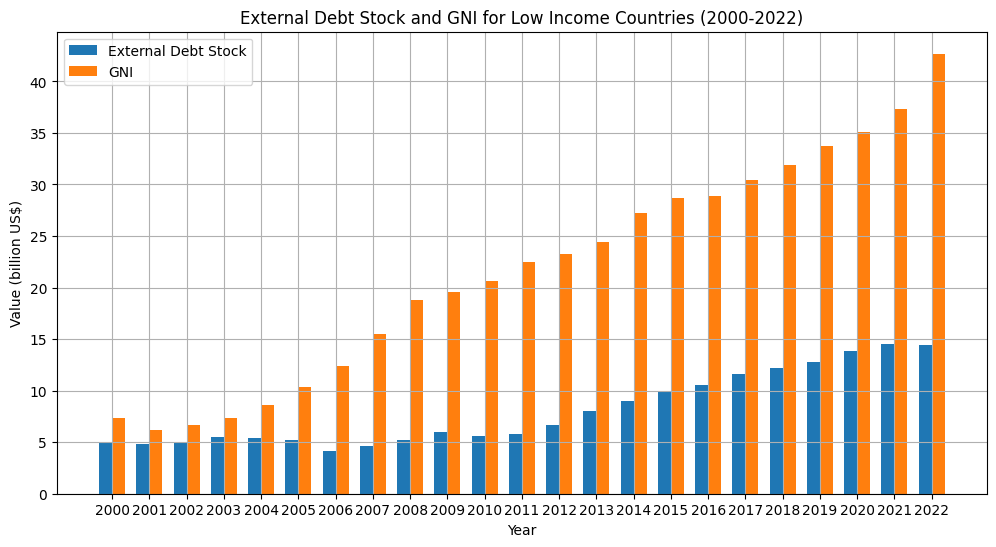

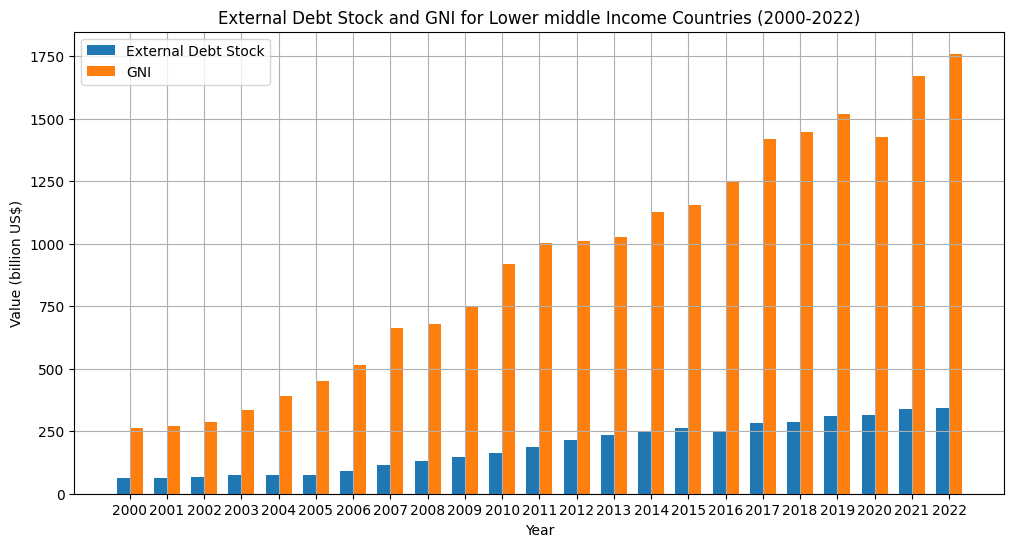

In [16]:
# histogram of external debt and GNI for low income countries

## Filter the data_FRED_WB_wide2 DataFrame to include only rows where the "Income group" column is equal to "Low income" and "Lower middle income" and "Year" is between 2000 and 2022

df_low_income_2000_2022 = data_FRED_WB_agg[(data_FRED_WB_agg['Income group'] == 'Low income') & (data_FRED_WB_agg['Year'] >= 2000) & (data_FRED_WB_agg['Year'] <= 2022)]

df_lower_middle_income_2000_2022 = data_FRED_WB_agg[(data_FRED_WB_agg['Income group'] == 'Lower middle income') & (data_FRED_WB_agg['Year'] >= 2000) & (data_FRED_WB_agg['Year'] <= 2022)]

df_low_income_2000_2022.head(10)

# Create the bar chart for low income countries
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = np.arange(len(df_low_income_2000_2022.index))

# Plot external debt stock
bars1 = ax.bar(index, df_low_income_2000_2022['External debt stocks, total (DOD, current US$)']/ 1e9, bar_width, label='External Debt Stock')

# Plot GNI
bars2 = ax.bar(index + bar_width, df_low_income_2000_2022['GNI (current US$)']/ 1e9, bar_width, label='GNI')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Value (billion US$)')
ax.set_title('External Debt Stock and GNI for Low Income Countries (2000-2022)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_low_income_2000_2022['Year'])
ax.legend()

plt.grid(True)
plt.show()

# Create the bar chart lower middle income countries
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = np.arange(len(df_lower_middle_income_2000_2022.index))

# Plot external debt stock
bars1 = ax.bar(index, df_lower_middle_income_2000_2022['External debt stocks, total (DOD, current US$)']/ 1e9, bar_width, label='External Debt Stock')

# Plot GNI
bars2 = ax.bar(index + bar_width, df_lower_middle_income_2000_2022['GNI (current US$)']/ 1e9, bar_width, label='GNI')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Value (billion US$)')
ax.set_title('External Debt Stock and GNI for Lower middle Income Countries (2000-2022)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_lower_middle_income_2000_2022['Year'])
ax.legend()

plt.grid(True)
plt.show()



In subsequent analysis, I often use the variable `External debt stocks (% of GNI)` that results from `External debt stocks, total (DOD, current US$)` and `GNI (current US$)`. Therefore, in the above graphs, one can see the evolution of the two latter variables over time which is useful to understand the changes in `External debt stocks (% of GNI)`.

In low income countries, the external debt level is pretty constant around 5 billion US dollars until 2011. Then it steadily increases until 2022 and almost reaches 15 billion US dollars. GNI fluctuates around 6.5 billion US dollars until 2003. It increases fast until 2008 and reaches 19 billion US dollars and continues to rise until 2022 but at a slower rate.

In lower middle income countries, external debt level fluctuates around 70 billion US dollar until 2005. It increases very fast until 2013 and then continues to rise but at a slower rate. It reaches 340 billion US dollar in 2022. In 2000, GNI is about 250 billion US dollars and slowly increases until 2002. Then, it steadily rises until 2022 and reaches the level of 1750 billion US dollar.

#### The relationship between exchange rate and external debt   

C:\Users\Maude\AppData\Local\Temp\ipykernel_27268\4086501351.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cur_comp_60_agg = df_cur_comp_60.groupby(['Income group', 'Year']).apply(lambda x: pd.Series({col: weighted_mean(x, col, 'Population, total') for col in value_columns})


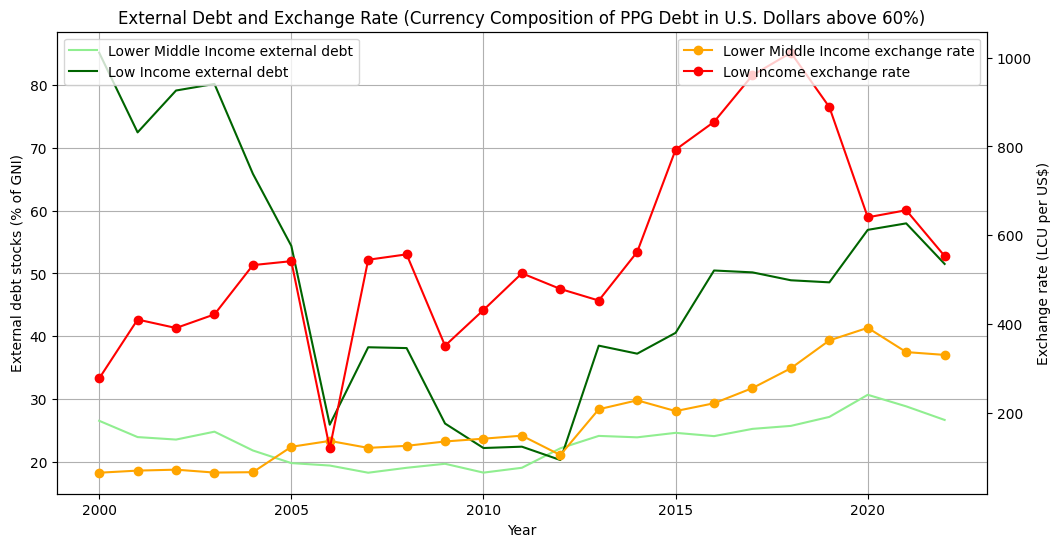

In [17]:
# relationship between the exchange rate and the external debt stocks (% of GNI) for countries whose currency composition of PPG debt in U.S. dollars is at least 60%

## Filter the data_FRED_WB_wide2 DataFrame to include only rows where the "Currency composition of PPG debt, U.S. dollars (%)" column is greater than or equal to 60%

df_cur_comp_60 = df_FRED_WB_wide2[(df_FRED_WB_wide2['Currency composition of PPG debt, U.S. dollars (%)'] >= 60) & (df_FRED_WB_wide2['Year'] >= 2000)]
## Aggregate df_cur_comp_60 by income group and year

df_cur_comp_60_agg = df_cur_comp_60.groupby(['Income group', 'Year']).apply(lambda x: pd.Series({col: weighted_mean(x, col, 'Population, total') for col in value_columns})
).reset_index()

## Filter the df_cur_comp_60_agg DataFrame to include only rows where the "Income group" column is equal to "Low income" and "Lower middle income"

df_low_income_cur_comp_60_agg = df_cur_comp_60_agg[df_cur_comp_60_agg['Income group'] == 'Low income']

df_lower_middle_income_cur_comp_60_agg = df_cur_comp_60_agg[df_cur_comp_60_agg['Income group'] == 'Lower middle income']

df_lower_middle_income_cur_comp_60_agg.head(50)

## Plot

# Plot the exchange rate and external debt stocks over time for countries with currency composition of PPG debt in U.S. dollars greater than or equal to 60%

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the external debt stocks on the first y-axis

ax1.plot(df_lower_middle_income_cur_comp_60_agg['Year'], df_lower_middle_income_cur_comp_60_agg['External debt stocks (% of GNI)'], color='lightgreen', label='Lower Middle Income external debt')
ax1.plot(df_low_income_cur_comp_60_agg['Year'], df_low_income_cur_comp_60_agg['External debt stocks (% of GNI)'], color='darkgreen', label='Low Income external debt')

ax1.set_xlabel('Year')
ax1.set_ylabel('External debt stocks (% of GNI)')
ax1.set_title('External Debt and Exchange Rate (Currency Composition of PPG Debt in U.S. Dollars above 60%)')
ax1.grid()
ax1.legend(loc='upper left')

# Create a second y-axis for the exchange rates
ax2 = ax1.twinx()
ax2.plot(df_lower_middle_income_cur_comp_60_agg['Year'], df_lower_middle_income_cur_comp_60_agg['Official exchange rate (LCU per US$, period average)'], marker='o', color='orange', label='Lower Middle Income exchange rate')
ax2.plot(df_low_income_cur_comp_60_agg['Year'], df_low_income_cur_comp_60_agg['Official exchange rate (LCU per US$, period average)'], marker='o', color='red', label='Low Income exchange rate')

ax2.set_ylabel('Exchange rate (LCU per US$)')
#ax2.set_ylim(0, 1500)  # 2008 is an outlier for lower middle income countries because of Zimbabwe
ax2.legend(loc='upper right')

plt.show()


I focus on countries whose currency composition in US dollar is above 60% because this is the channel I am exploring. Indeed, if the US dollar appreciates relative to the local currency and the external debt is largely composed by US dollar, then the value of the external debt in local currency will increase. Therefore, I expect a positive correlation between the exchange rate and the external debt. I use data from 2000 since earlier there is not so much data on the debt composition.

Until 2005, the correlation between exchange rate and external debt for low and lower middle income countries is negative. For both income groups, I observe a depreciation of the local currency and a decrease in the external debt.

From 2005, the general trends of external debt and exchange rate are increasing. The data for low income countries is very volatile in both variables. The local currencies depreciate and the external debt increase until 2008. The local currency appreciates a lot in 2009 and the external debt decreases until reaching its lowest level in 2012. Then the local currency depreciates until reaching its weakest value in 2018, and the external debt increases until 2021. After that, both the exchange rate and the external debt decrease. By contrast, the trends for lower middle income countries is much smoother. The exchange rate and the external debt remain almost constant until 2011, then they both increase and reach their highest level in 2020. Finally, they decrease from 2020 to 2022.

### Models

#### OLS regressions

In [18]:
# add a column US interest rates

us_interest_rate = df_FRED_WB_wide2[df_FRED_WB_wide2['Country Name'] == 'United States'][['Year', 'Interest rate']]
us_interest_rate.rename(columns={'Interest rate': 'US interest rate'}, inplace=True)
df_FRED_WB_wide2 = pd.merge(df_FRED_WB_wide2, us_interest_rate, on='Year', how='left')

df_FRED_WB_wide2.head(10)

#Filter the data_FRED_WB_wide2 DataFrame to include only rows where the "Income group" column is equal to "Low income" and "Lower middle income"

df_developing = df_FRED_WB_wide2[(df_FRED_WB_wide2['Income group'] == 'Low income')|(df_FRED_WB_wide2['Income group'] == 'Lower middle income')]


In [19]:
# naive OLS

# Define the dependent variable (Y) and independent variables (X)
Y = df_developing['External debt stocks (% of GNI)']
X = df_developing['US interest rate']

# Combine Y and X into a single DataFrame to drop NaN values
df_ols = pd.concat([Y, X], axis=1).dropna()

# Separate the cleaned DataFrame back into Y and X
Y_clean = df_ols['External debt stocks (% of GNI)']
X_clean = df_ols['US interest rate']

# Add a constant to the independent variables
X_clean = sm.add_constant(X_clean)

# Run the OLS regression
model_naive = sm.OLS(Y_clean, X_clean).fit()

# Print the regression results
#print(model_naive.summary())

#df_developing.head(10)

In [20]:
#OLS with controls

# Define the dependent variable (Y) and independent variables (X)
Y = df_developing['External debt stocks (% of GNI)']
X = df_developing[['US interest rate',
                  'Official exchange rate (LCU per US$, period average)',
                  'GNI per capita, PPP (current international $)',
                  'Currency composition of PPG debt, U.S. dollars (%)',
                  'Population, total']]

# Combine Y and X into a single DataFrame to drop NaN values
df_ols = pd.concat([Y, X], axis=1).dropna()

# Separate the cleaned DataFrame back into Y and X
Y_clean = df_ols['External debt stocks (% of GNI)']
X_clean = df_ols[['US interest rate',
                  'Official exchange rate (LCU per US$, period average)',
                  'GNI per capita, PPP (current international $)',
                  'Currency composition of PPG debt, U.S. dollars (%)',
                  'Population, total']]

# Add a constant to the independent variables
X_clean = sm.add_constant(X_clean)

# Run the OLS regression
model_controls = sm.OLS(Y_clean, X_clean).fit()

# Print the regression results
#print(model_controls.summary())



In [21]:
# OLS with country and year fixed effects

Y = df_developing['External debt stocks (% of GNI)']
X = df_developing[['US interest rate',
                  'Official exchange rate (LCU per US$, period average)',
                  'GNI per capita, PPP (current international $)',
                  'Currency composition of PPG debt, U.S. dollars (%)',
                  'Population, total',
                  'Country Name',
                  'Year']]

# Combine Y and X into a single DataFrame to drop NaN values
df_ols = pd.concat([Y, X], axis=1).dropna()

# Create the design matrices using patsy
y, X = patsy.dmatrices('Q("External debt stocks (% of GNI)") ~ Q("US interest rate") + Q("Official exchange rate (LCU per US$, period average)") + Q("GNI per capita, PPP (current international $)") + Q("Currency composition of PPG debt, U.S. dollars (%)") + Q("Population, total") + C(Q("Country Name")) + C(Year)', data=df_ols, return_type='dataframe')

# Rename the columns in the design matrix to match the other models
X.rename(columns={
    'Q("US interest rate")': 'US interest rate',
    'Q("Official exchange rate (LCU per US$, period average)")': 'Official exchange rate (LCU per US$, period average)',
    'Q("GNI per capita, PPP (current international $)")': 'GNI per capita, PPP (current international $)',
    'Q("Currency composition of PPG debt, U.S. dollars (%)")': 'Currency composition of PPG debt, U.S. dollars (%)',
    'Q("Population, total")': 'Population, total',
    'Intercept': 'const'
}, inplace=True)

# Run the OLS regression
model_fe = sm.OLS(y, X).fit()

# Print the regression results
#print(model_fe.summary())



In [22]:
# Comparing the three models

# Create a summary table to compare the three models
summary_OLS = summary_col([model_naive, model_controls, model_fe],
                      stars=True,
                      model_names=['Naive Model', 'Controls Model', 'Fixed Effects Model'],
                      info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                 'No. observations': lambda x: f"{int(x.nobs)}"})

print(summary_OLS)


                                                     Naive Model Controls Model Fixed Effects Model
---------------------------------------------------------------------------------------------------
const                                                59.8195***  44.5608***     37.9323**          
                                                     (1.9728)    (6.0798)       (17.3427)          
US interest rate                                     1.0477***   7.2276***      8.8152***          
                                                     (0.3363)    (0.7392)       (1.2517)           
Official exchange rate (LCU per US$, period average)             0.0000***      0.0000***          
                                                                 (0.0000)       (0.0000)           
GNI per capita, PPP (current international $)                    -0.0009        0.0071***          
                                                                 (0.0006)       (0.0012)           

In this table, three OLS models are summarized to study mainly the relationship between the US interest rate and the external debt in developing countries. Indeed, I expect that a rise in the US interest rate leads to an appreciation of the US dollar which increases the external debt burden of developing countries. 

The naive model is simply a correlation between the US interest rate and the external debt. The correlation is positive and significant as expected. A rise by one point in the US interest rate is correlated with a rise by 1.05% in the external debt stock as a percentage of the GNI.

The second model includes the following controls: the exchange rate, GNI per capita, the currency composition of the debt, the population. The coefficient of interest is still positive and significant, but its magnitude has increased a lot compared to the correlation. Therefore, an increase in the US interest rate by one point is here correlated with a rise by 7.23 in the external debt stock as a percentage of the GNI. Moreover, the exchange rate is positively and significantly correlated with external debt, buts its magnitude seems to be low. The currency composition is also positively and significantly correlated with external debt. Population is negatively correlated with external debt.

The last model includes in addition country and year fixed effects. The coefficient of US interest rate is very similar to the one obtained in the model with controls, but its magnitude is even larger. Therefore, an increase in the US interest rate by one point is associated with an increase in the external debt as percentage of GNI by 8.82. Furthermore, the coefficient of the exchange rate remains unchanged. Nevertheless, including fixed effects change a lot the coefficients of other controls. The GNI per capita is now positively and significantly associated with the external debt. The currency composition is negatively correlated and population is not significant anymore. Let's note that including fixed effects tremendously increase the R-squared from 0.08 to 0.46, which confirms the important of fixed effects in this context.

#### ARMAX  

In [23]:
#ARMAX with US interest rate as exogenous variable

# Prepare the data
y = df_developing['External debt stocks (% of GNI)']
X = df_developing[['US interest rate']]

# Define the range for p and q
p = range(0, 5)  # You can adjust the range as needed
q = range(0, 5)  # You can adjust the range as needed

# Generate all combinations of p and q
pq_combinations = list(itertools.product(p, q))

# Initialize variables to store the best model and its AIC
best_aic1 = float('inf')
best_order1 = None
best_model1 = None

# Iterate over all combinations of p and q
for order in pq_combinations:
    try:
        # Fit the ARMAX model
        model = sm.tsa.SARIMAX(y, exog=X, order=(order[0], 0, order[1]))
        results = model.fit(disp=False)
        
        # Check if the current model has the lowest AIC
        if results.aic < best_aic1:
            best_aic1 = results.aic
            best_order1 = order
            best_model1 = results
    except:
        continue

# Print the best order and the summary of the best model
#print(f'Best order: {best_order1}')
#print(best_model1.summary())

c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupp

In [25]:

#ARMAX with 'US interest rate' and the controls as exogenous variables

# Prepare the data
y = df_developing['External debt stocks (% of GNI)']
X = df_developing[['US interest rate',
                  'Official exchange rate (LCU per US$, period average)',
                  'GNI per capita, PPP (current international $)',
                  'Currency composition of PPG debt, U.S. dollars (%)',
                  'Population, total']]

# Drop rows with NaN values in the exogenous variables
X = X.dropna()

# Align the dependent variable with the exogenous variables
y = y.loc[X.index]

# Define the range for p and q
p = range(0, 5)  # You can adjust the range as needed
q = range(0, 5)  # You can adjust the range as needed

# Generate all combinations of p and q
pq_combinations = list(itertools.product(p, q))

# Initialize variables to store the best model and its AIC
best_aic2 = float('inf')
best_order2 = None
best_model2 = None

# Iterate over all combinations of p and q
for order in pq_combinations:
    try:
        # Fit the ARMAX model
        model = sm.tsa.SARIMAX(y, exog=X, order=(order[0], 0, order[1]))
        results = model.fit(disp=False)
        
        # Check if the current model has the lowest AIC
        if results.aic < best_aic2:
            best_aic2 = results.aic
            best_order2 = order
            best_model2 = results
    except Exception as e:
        print(f"Error fitting model with order {order}: {e}")
        continue

# Check if a best model was found
#if best_model2 is not None:
#    # Print the best order and the summary of the best model
#    print(f'Best order: {best_order2}')
#    print(best_model2.summary())
#else:
#    print("No valid model was found.")


c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Maude\miniconda3\envs\env_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

In [26]:
# comparison of best_model1 and best_model2 in a table

summary_armax = summary_col([best_model1, best_model2],
                      stars=True,
                      model_names=['Model 1', 'Model 2'],
                      info_dict={'R-squared': lambda x: f"{x.rsquared:.2f}",
                                 'No. observations': lambda x: f"{int(x.nobs)}"})

summary_armax

,Model 1,Model 2
US interest rate,-0.3979,10.5684***
,(0.3083),(0.0032)
ar.L1,0.2686***,0.8425***
,(0.0240),(0.0207)
ar.L2,0.6202***,
,(0.0235),
ma.L1,0.7205***,0.0663***
,(0.0257),(0.0247)
ma.L2,0.1083***,0.0163
,(0.0085),(0.0244)


This table summarizes the coefficients of two AutoRegressive Moving Average models with eXogenous inputs (ARMAX) models. ARMAX models includes three parts: 1) autoregressive, 2) moving averag, and 3) exogenous variables.  ARMAX estimate the relationship between the dependent variable and its past values as well as exogenous variables.

The model 1 only includes the US interest rate as exogenous variables. Based on Akaike information criterion (AIC), the best model is ARMAX(2,4). US interest rate is not statistically significant. All the autoregressive and moving average coefficients are positive and statistically significant. It is important to notice that the coefficient of the moving average with one lag ($ e_{t-1}$) has the largest magnitude. Moreover, the coefficient of the autoregressive with two lags ($ Y_{t-2}$), which corresponds to the external debt two periods earlier, has also a large magnitude in comparison to other coefficients. Therefore, these two coefficients will influence more the current external debt than the other coefficients.

Model 2 contains US interest rate, exchange rate, GNI per capita, currency composition of the debt, population as exogenous variables. The best model is ARMAX(1,4) using AIC. The coefficients of US interest rate is positive and statistically significant. It implies that an increase in the US interest rate by one percentage point is associated with an increase in the external debt by 10.57 percentage points. Although this effect has a somewhate larger magnitude than the OLS model with fixed effects, it is in the same range. External debt in the previous period is positive as well as statistically significant, and the magnitude of its coefficient is large. The coefficients of the moving average with one and four lags are statistically significant. The effects of exchange rate and the currency composition of the debt are positive and highly significant, while the coefficient of population is negative and significant.

Model 2 seems to be a better model because it contains more information on the predictors of the external debt. Its conclusion on the effect of US interest rate on external debt corresponds to our findings with OLS including fixed effects, which confirms the relevance of this model.

## Conclusion

This project investigates the relationship between the US interest rates and the public debt in developing countries. I find that a one-percentage-point raise in the US interest rate is associated with a 8-10 percentage-point increase in the external debt as a percentage of GNI. This result highlights the significant impact of US interest rates on the external debt burden of developing countries, mainly through the exchange rate mechanism.

As a result, the monetary tightening in the US following the Russo-Ukrainian war has increased the debt burden of developing countries, many of which were already economically vulnerable. Debt unsustainability increases the risk of financial instability and economic crises in these regions.